In [10]:
import pandas as pd
import math
from collections import Counter
from scipy import stats as scs
from datetime import datetime
from scipy.stats import linregress

In [2]:
# first, read in the datafiles
mt = pd.read_csv("./Data/MT-clean/MT_cleaned.csv")
vt = pd.read_csv("./Data/VT-clean/VT_cleaned.csv")

C:\Users\Maita Schade\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Maita Schade\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Proportion of males among stopped -- divide number of VT males by total
male_prop = vt[vt.driver_gender=='M'].shape[0]/vt.shape[0]
print("% male: ", male_prop)

% male:  0.6342658453500891


In [4]:
# Probability of arrest -- divide number of out-of-state arrests by total number of out-of-state, & same for in
# then do chi2-test

# crosstab
result = pd.crosstab(mt.is_arrested, mt.out_of_state)
print(result)

# calculate each probability
out_prob = result[True][True]/result[True].sum()
in_prob = result[False][True]/result[False].sum()
print('ratio of probabilities: ', out_prob/in_prob)

(chi2, p, dof, expected) = scs.chi2_contingency(result)
print("chi2 = ", chi2, "\n",
      "p = ", p)


out_of_state   False   True 
is_arrested                 
False         604588  198773
True           12190    4868
ratio of probabilities:  1.2095129351452942
chi2 =  128.72916324226682 
 p =  7.773353035854224e-30


In [5]:
# speeding violations -- pick up all the MT violations that contain speeding
mt[mt.violation.map(lambda s: 'Speeding' in str(s))].shape[0]/mt.shape[0]

0.6580998111785223

In [6]:
# DUI -- DUI violation as proportion of total violations in each state, then get ration between MT & VT

dui_mt = mt.violation[mt.violation.map(lambda s: 'DUI' in str(s))].shape[0]/mt.shape[0]
dui_vt = vt.violation[vt.violation.map(lambda s: 'DUI' in str(s))].shape[0]/vt.shape[0]

print(dui_mt/dui_vt)

4.085999694420856


In [11]:
# Model year

# function for some type handling...
def floatcast(obj):
    try:
        return float(obj)
    except:
        return None
    
# variables of interest
model_year = mt[["stop_date","vehicle_year"]]

# first get the stop year. 
model_year.stop_date = mt.stop_date.map(lambda s: datetime.strptime(s, "%Y-%m-%d").year if type(s)==str else None)

# then turn vehicle model year into floats for regression
model_year.vehicle_year = model_year.vehicle_year.apply(floatcast)
print (model_year.shape)
# and pick only the rows that have values for both stop and model year
model_year = model_year[~model_year.stop_date.isna() & ~model_year.vehicle_year.isna()]
print (model_year.shape)
# we lose about 7500 stop data points

C:\Users\Maita Schade\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(825118, 2)
(817720, 2)


In [12]:
# now use scipy for a quick regression on the two variables.
regression = linregress(model_year.stop_date, model_year.vehicle_year)
print(regression)
MY_predictor= lambda year: regression.intercept + regression.slope * year
MY_predictor(2020)

LinregressResult(slope=0.72313020112513, intercept=548.1578839829197, rvalue=0.20526250525672282, pvalue=0.0, stderr=0.003812920677505308)


2008.8808902556823

In [13]:
# Do the whole thing again for the *average* model year given the stop year. shouldn't be much different.
year_ave = pd.DataFrame(columns=["stop_date","ave_model_year"])
for year in Counter(model_year.stop_date):
    year_ave = year_ave.append(pd.DataFrame([[year, model_year['vehicle_year'][model_year.stop_date==year].mean()]],
                                  columns=["stop_date","ave_model_year"]), 
                    ignore_index=True)

In [14]:
# Another regression...
regression = linregress(year_ave)
regression.pvalue

5.609148253703464e-08

In [15]:
# and prediction.
MY_predictor= lambda year: regression.intercept + regression.slope * year
MY_predictor(2020)

2008.8431659593393

In [16]:
# Timing of stops 
# First, combine all the stops together and make sure they actually have a timestamp.
allstops = vt.append(mt)
allstops = allstops[~allstops.stop_time.isna()]

# Then, get the stop hour for each stop and store it in an extra column
allstops["stop_hr"] = allstops.stop_time.apply(lambda s: datetime.strptime(s,"%H:%M").hour)

In [17]:
# find which hour has the most and the least traffic stops...
hour_dist = pd.DataFrame(Counter(allstops.stop_hr), index=["count"]).transpose()
print(hour_dist.iloc[hour_dist.idxmax()])
print(hour_dist.iloc[hour_dist.idxmin()])
# ... and calculate the difference.
hour_dist.max()-hour_dist.min()

    count
15  95891
   count
4    547


count    95344
dtype: int64

In [18]:
# County size
# pick out all the separate counties
names = mt.county_name[~mt.county_name.isna()].unique()

# for each county, go about finding its "size"
maxsize=0
for this_county in names:
    # get the coordinates
    county_coord = mt[(mt.county_name==this_county) & 
                      (~mt.lat.isna()) & 
                      (~mt.lon.isna())][["lat","lon"]]

    # truncate the locations observed by 10 standard deviations out from center, based on some plots and 
    # checks how these are distributed
    reasonable_loc = county_coord[(county_coord.lat.apply(lambda l: abs(l-county_coord.lat.mean()))<10*county_coord.lat.std()) &
                                  (county_coord.lon.apply(lambda l: abs(l-county_coord.lon.mean()))<10*county_coord.lon.std())] 

    
    # get the spread in lat and lon after truncation
    d_lat = reasonable_loc.lat.std()
    d_lon = reasonable_loc.lon.std()
    lat = reasonable_loc.lat.mean()
    
    # use a quick and dirty estimate of km based on Wikipedia numbers and geometry
    est_height = 111.132*d_lat
    est_width = 111.320*math.cos(math.radians(lat))*d_lon
    # and calculate the elipsis' area
    A = math.pi*est_height*est_width
    
    # keep track, and reset max if this county is bigger
    print(this_county, A)
    maxsize=max(A,maxsize)
    
print('largest county size: ', maxsize, ' km^2')

Cascade County 726.0110879079077
Missoula County 451.4396366704828
Ravalli County 173.66036067958035
Yellowstone County 474.70417171811243
Gallatin County 732.7333226769787
Silver Bow County 180.47771563659794
Flathead County 330.3514276213981
Mineral County 588.107227175585
Jefferson County 1354.2293752870366
Rosebud County 982.065357660048
Lake County 490.8532591713153
Stillwater County 261.5274825871419
Fergus County 1497.9527666724655
Judith Basin County 1075.1372345638838
Deer Lodge County 110.85716386283202
Custer County 531.8257898168524
Powell County 707.8801919281345
Roosevelt County 849.6143016904398
Daniels County 232.4769157202195
Park County 504.0019282986921
Sanders County 1520.1495897117481
Hill County 385.28920418604883
Beaverhead County 1364.2454308560193
Lincoln County 2189.168687891612
Lewis And Clark County 714.7902967117282
Glacier County 882.7506654664514
Carbon County 675.3098772177211
Madison County 1794.7702076586331
Big Horn County 571.6423061723016
Broadwater

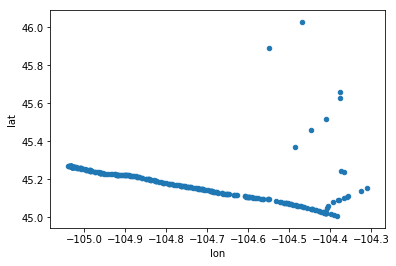

In [181]:
reasonable_loc.plot.scatter(x='lon',y='lat')

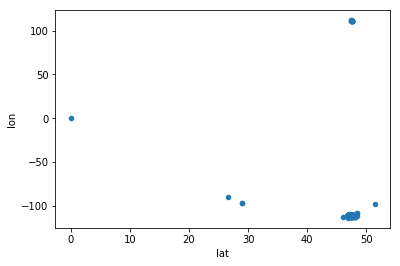

In [174]:
county_coord.plot.scatter(x='lat',y='lon')